<a href="https://colab.research.google.com/github/RHMalalatiana/Recombination_code/blob/main/Value_SandZ_rec_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pyvolve

In [3]:
import math as mt
import random
from Bio import SeqIO
import pyvolve
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.special import ndtri

In [4]:
def zFunc(ab,ac,bc):
  dist_sort=np.sort([ab,ac,bc])
  ab=dist_sort[0]
  ac=dist_sort[1]
  bc=dist_sort[2]
  result=(bc-ac)/mt.sqrt(ab) if ab>0 else 0
  return(result)

In [5]:
def hamming_distance(seq1,seq2):
    """
    This function compute the difference between two sequences
    """
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of equal length")
    sum=0
    for i in range(len(seq1)):
        if seq1[i]!=seq2[i]:
            sum+=1
    return sum

In [6]:
def distance_matrix(seq):
  N=len(seq)
  d=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      d[i,j]=hamming_distance(seq[i],seq[j])
      d[j,i]=d[i,j]
  return d

pyvolve library

https://sjspielman.github.io/pyvolve/model.html#module-model

Here I simulate tree of 4 sequences and calculate the Z-score between all the triplet.

Conclusion: We should take care of the choice of triplet


In [7]:
n_simulation=1

for i in range(n_simulation):
  seq=dict()
  # Define the tree (branch lengths represent time)
  tree = pyvolve.read_tree(tree="((A:0.5,B:0.5):0.5,(C:0.5,D:0.5):0.5);")
  # Define a simple nucleotide model
  model = pyvolve.Model("nucleotide")
  # model = pyvolve.Model("nucleotide", {
    # "state_freqs": [0.25, 0.25, 0.25, 0.25],  # A, C, G, T
    # "rate_matrix": [
        # [0, 1, 1, 1],
        # [1, 0, 1, 1],
        # [1, 1, 0, 1],
        # [1, 1, 1, 0]
    # ]
    # })
  # Define a partition with the model and a sequence length
  partition = pyvolve.Partition(models=model, size=2000)
  # Evolve sequences along the tree
  evolver = pyvolve.Evolver(partitions=partition, tree=tree)
  evolver(seqfile="my_simulation_output.fasta")  # Outputs to a file
  for record in SeqIO.parse("my_simulation_output.fasta", "fasta"):
    seq[record.id]=record.seq
  d=distance_matrix(list(seq.values()))
  seqname=list(seq.keys())
  N=len(seq)
  # Step 1: Enumerate all triplets
  triplets = list(itertools.combinations(range(N), 3))
  Z_scores = dict()
  for a, b, c in triplets:
    # print(f"triplet:({seqname[a],seqname[b],seqname[c]})")
    dAB=d[a][b]
    dAC=d[a][c]
    dBC=d[b][c]
    # print(f"d_{seqname[a]}{seqname[b]}={dAB}")
    # print(f"d_{seqname[a]}{seqname[c]}={dAC}")
    # print(f"d_{seqname[b]}{seqname[c]}={dBC}")
    # print(f"----------------------------------")
    Z = zFunc(dAB, dAC, dBC)
    Z_scores[(seqname[a], seqname[b], seqname[c])]=Z
  print(Z_scores)

{('A', 'B', 'C'): np.float64(-0.9329903614147113), ('A', 'B', 'D'): np.float64(-0.1805787796286538), ('A', 'C', 'D'): np.float64(-0.02990743022772896), ('B', 'C', 'D'): np.float64(-1.1364823486537006)}


In [9]:
critical_value=ndtri(1-(0.05/(2*len(triplets))))
print(f"Critical value: {critical_value}")

Critical value: 2.497705474412374


Here I simulate recombination

In [10]:
def simulate_recombination(seq1, seq2, recombination_rate):
    """
    Simulates recombination along two sequences based on a given recombination rate.

    Args:
        seq1 (str): First DNA sequence (parent 1).
        seq2 (str): Second DNA sequence (parent 2).
        recombination_rate (float): Probability of recombination at each position (between 0 and 1).

    Returns:
        str: Recombinant sequence.
        list: List of recombination points.
    """
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of equal length.")

    length = len(seq1)
    recombinant_seq = []
    current_parent = seq1  # Start from first parent
    recombination_points = []

    for i in range(length):
        # Decide whether to switch parent sequences based on recombination rate
        if random.random() < recombination_rate:
            current_parent = seq2 if current_parent == seq1 else seq1
            recombination_points.append(i)  # Store recombination position

        recombinant_seq.append(current_parent[i])  # Append current base

    return "".join(recombinant_seq)

Run 100 simulation (Computing the Z score)

Generating sequences using pyvolve, Tree model ((AB)C)

Transform B sequences to a recombination of A and C. Recombination rate=0.01

Computing Z

In [11]:
list_Z=[]
n_simulation=100
for i in range(n_simulation):
  seq=dict()
  # Define the tree (branch lengths represent time)
  tree = pyvolve.read_tree(tree="((A:0.1,B:0.1):0.1,(C:0.1,D:0.1):0.1);")
  # Define a simple nucleotide model
  model = pyvolve.Model("nucleotide")
  # Define a partition with the model and a sequence length
  partition = pyvolve.Partition(models=model, size=1000)
  # Evolve sequences along the tree
  evolver = pyvolve.Evolver(partitions=partition, tree=tree)
  evolver(seqfile="my_simulation_output.fasta")  # Outputs to a file
  for record in SeqIO.parse("my_simulation_output.fasta", "fasta"):
    seq[record.id]=record.seq
  recombination_rate=0.01
  seq['B']=simulate_recombination(seq['A'], seq['C'], recombination_rate)
  ab=hamming_distance(seq['A'],seq['B'])
  ac=hamming_distance(seq['A'],seq['C'])
  bc=hamming_distance(seq['B'],seq['C'])
  list_Z.append(zFunc(ab,ac,bc))

critical value: \begin{equation}
            Z_{threshold}=\Phi^{-1}\left(1-\frac{\alpha}{2N_{simulation}}\right)
        \end{equation}

In [12]:
critical_value=ndtri(1-(0.05/(2*n_simulation)))
print(f"Critical value: {critical_value}")

Critical value: 3.4807564043462422


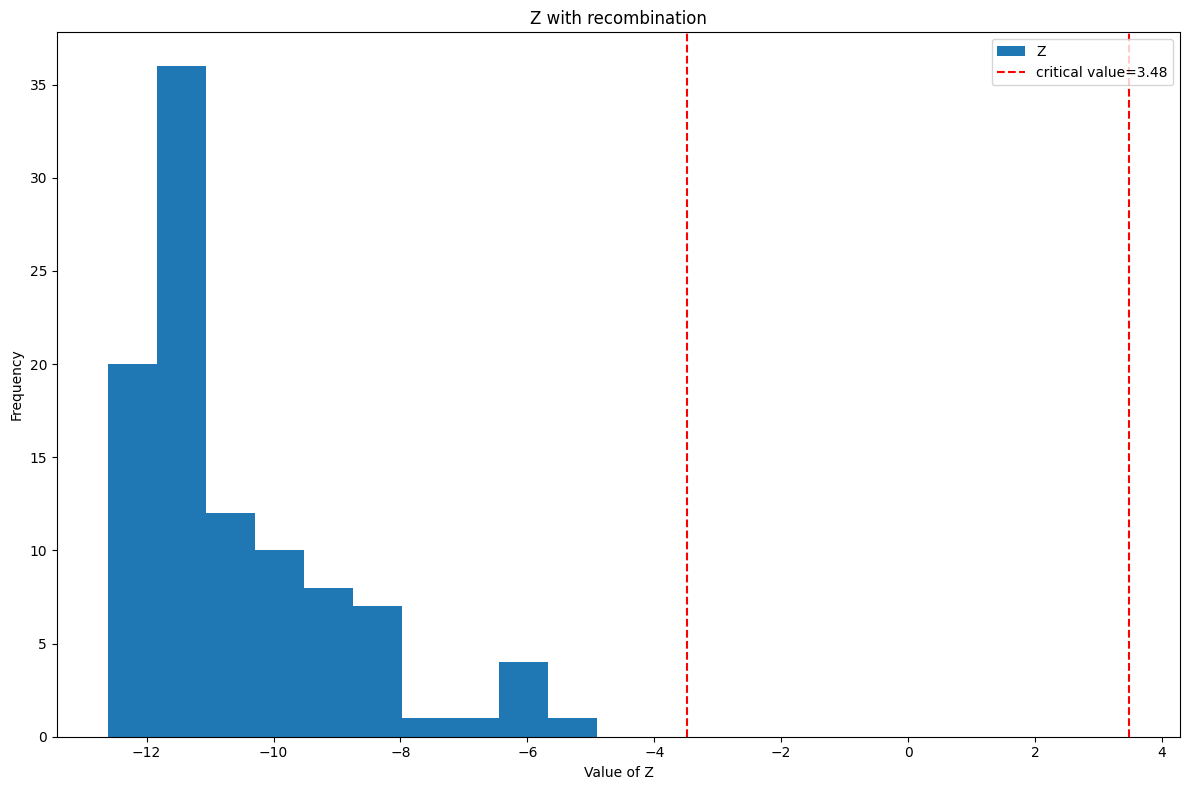

In [13]:
plt.figure(figsize=(12, 8))
plt.hist(list_Z, bins=10, label="Z")
plt.axvline(x=critical_value, color='r', linestyle='--',label=f'critical value={critical_value:.2f}')
plt.axvline(x=-critical_value, color='r', linestyle='--')
plt.xlabel("Value of Z")
plt.ylabel("Frequency")
plt.legend()
plt.title("Z with recombination")

plt.tight_layout()
plt.show()

We do the same simulation but the data used here is data with no recombination

In [14]:
list_Z=[]
n_simulation=100
for i in range(n_simulation):
  seq=dict()
  # Define the tree (branch lengths represent time)
  tree = pyvolve.read_tree(tree="((A:0.1,B:0.1):0.1,(C:0.1,D:0.1):0.1);")
  # Define a simple nucleotide model
  model = pyvolve.Model("nucleotide")
  # Define a partition with the model and a sequence length
  partition = pyvolve.Partition(models=model, size=1000)
  # Evolve sequences along the tree
  evolver = pyvolve.Evolver(partitions=partition, tree=tree)
  evolver(seqfile="my_simulation_output.fasta")  # Outputs to a file
  for record in SeqIO.parse("my_simulation_output.fasta", "fasta"):
    seq[record.id]=record.seq
  ab=hamming_distance(seq['A'],seq['B'])
  ac=hamming_distance(seq['A'],seq['C'])
  bc=hamming_distance(seq['B'],seq['C'])
  list_Z.append(zFunc(ab,ac,bc))

In [15]:
critical_value=ndtri(1-(0.05/(2*n_simulation)))
print(f"Critical value: {critical_value}")

Critical value: 3.4807564043462422


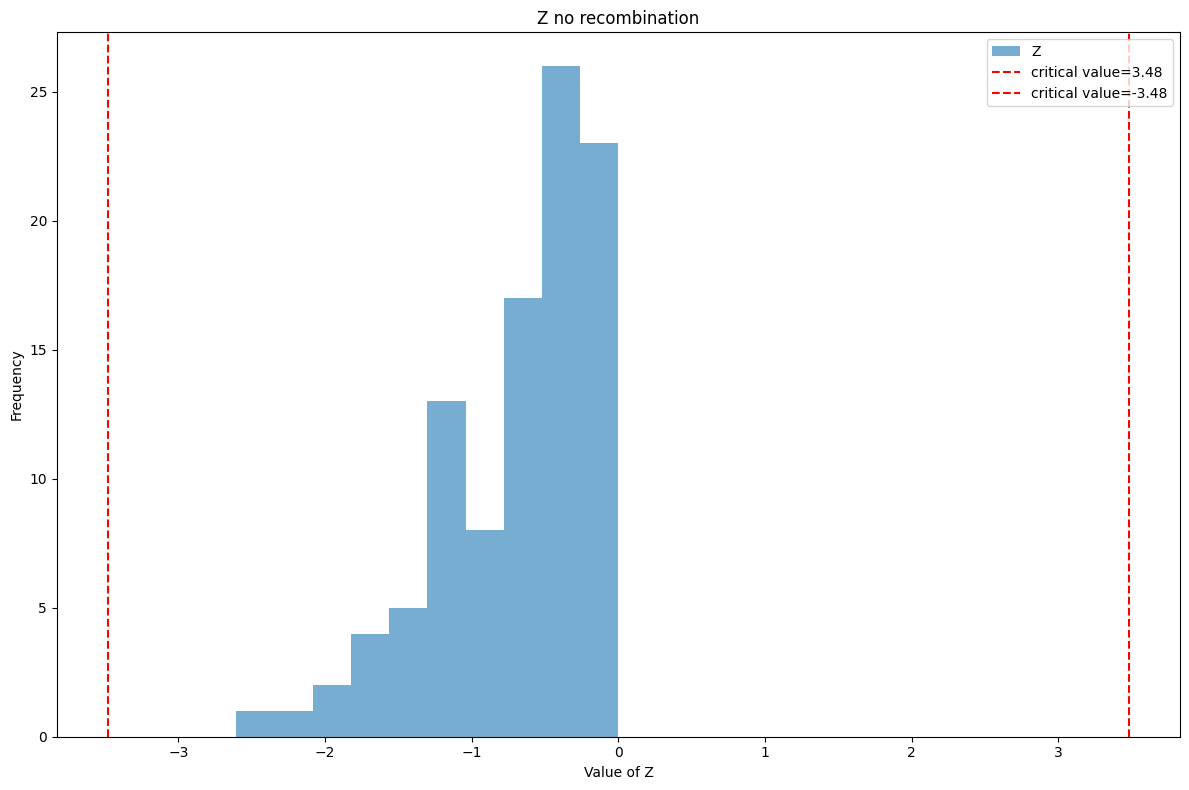

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(list_Z, bins=10, alpha=0.6, label="Z")
plt.axvline(x=critical_value, color='r', linestyle='--',label=f'critical value={critical_value:.2f}')
plt.axvline(x=-critical_value, color='r', linestyle='--',label=f'critical value={-critical_value:.2f}')
plt.xlabel("Value of Z")
plt.ylabel("Frequency")
plt.legend()
plt.title("Z no recombination")

plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import scipy.stats as stats

# Create a standard normal distribution (mean=0, std=1)
standard_normal = stats.norm(loc=0, scale=1)

# Calculate the probability density at x=1
pdf_value = standard_normal.pdf(1.96)
print(f"PDF at x=1.96: {pdf_value:.3f}")

# Calculate the probability of getting a value less than or equal to 1
cdf_value = standard_normal.cdf(1)
print(f"CDF at x=1: {cdf_value:.4f}")

# Find the x value for which the CDF is 0.95 (95th percentile)
ppf_value = standard_normal.ppf(0.95)
print(f"PPF at q=0.95: {ppf_value:.4f}")

# Generate 5 random samples from the distribution
random_samples = standard_normal.rvs(size=5)
print(f"Random samples: {random_samples}")

# Example with a different mean and std
normal_distribution = stats.norm(loc=5, scale=2)
x_values = np.linspace(0, 10, 100)
pdf_values = normal_distribution.pdf(x_values)

PDF at x=1.96: 0.058
CDF at x=1: 0.8413
PPF at q=0.95: 1.6449
Random samples: [ 0.11127955  1.2324108  -0.30046712  0.46528577  0.0648107 ]
